In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro, jarque_bera, anderson
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

Estrategia de preprocesamiento de datos

Dado que el objetivo del proyecto es predecir el nivel de engagement del jugador (Low, Medium, High) mediante clasificación multiclase, el preprocesamiento se orientará a preparar los datos de forma adecuada para distintos algoritmos de aprendizaje supervisado. La variable PlayerID será eliminada al no aportar información predictiva. Las variables categóricas (Gender, Location, GameGenre y GameDifficulty) se transformarán mediante One-Hot Encoding, permitiendo su uso en modelos como la regresión logística multiclase, Random Forest y otros clasificadores.

Las variables numéricas serán escaladas utilizando StandardScaler, especialmente relevante para modelos sensibles a la escala como la regresión logística multiclase (One-vs-Rest o multinomial), que se utilizará como modelo baseline. No se aplicará eliminación sistemática de outliers, ya que estos representan comportamientos reales de jugadores intensivos. Finalmente, los datos se dividirán en conjuntos de entrenamiento y prueba mediante un split 80/20, integrando todo el flujo de transformación y modelado mediante Pipeline y ColumnTransformer de scikit-learn, garantizando reproducibilidad y evitando fugas de información.

In [ ]:
df = pd.read_csv('../../data/data.csv')
print(df.columns)
print(df.info())

Index(['PlayerID', 'Age', 'Gender', 'Location', 'GameGenre', 'PlayTimeHours',
       'InGamePurchases', 'GameDifficulty', 'SessionsPerWeek',
       'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked',
       'EngagementLevel'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSe

In [3]:
X = df.drop(columns=["PlayerID", "EngagementLevel"])
y = df["EngagementLevel"]
X = pd.get_dummies(X, columns=['Gender', 'Location', 'GameGenre', 'GameDifficulty'], drop_first=True)

print(X.columns)
print(X.info())


Index(['Age', 'PlayTimeHours', 'InGamePurchases', 'SessionsPerWeek',
       'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked',
       'Gender_Male', 'Location_Europe', 'Location_Other', 'Location_USA',
       'GameGenre_RPG', 'GameGenre_Simulation', 'GameGenre_Sports',
       'GameGenre_Strategy', 'GameDifficulty_Hard', 'GameDifficulty_Medium'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        40034 non-null  int64  
 1   PlayTimeHours              40034 non-null  float64
 2   InGamePurchases            40034 non-null  int64  
 3   SessionsPerWeek            40034 non-null  int64  
 4   AvgSessionDurationMinutes  40034 non-null  int64  
 5   PlayerLevel                40034 non-null  int64  
 6   AchievementsUnlocked       40034 non-null  int64  


# Arbol de decisión

Accuracy: 88.72%
Mejores parámetros: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
Accuracy en el conjunto de prueba: 0.8995
Accuracy con modelo optimizado: 83.34%


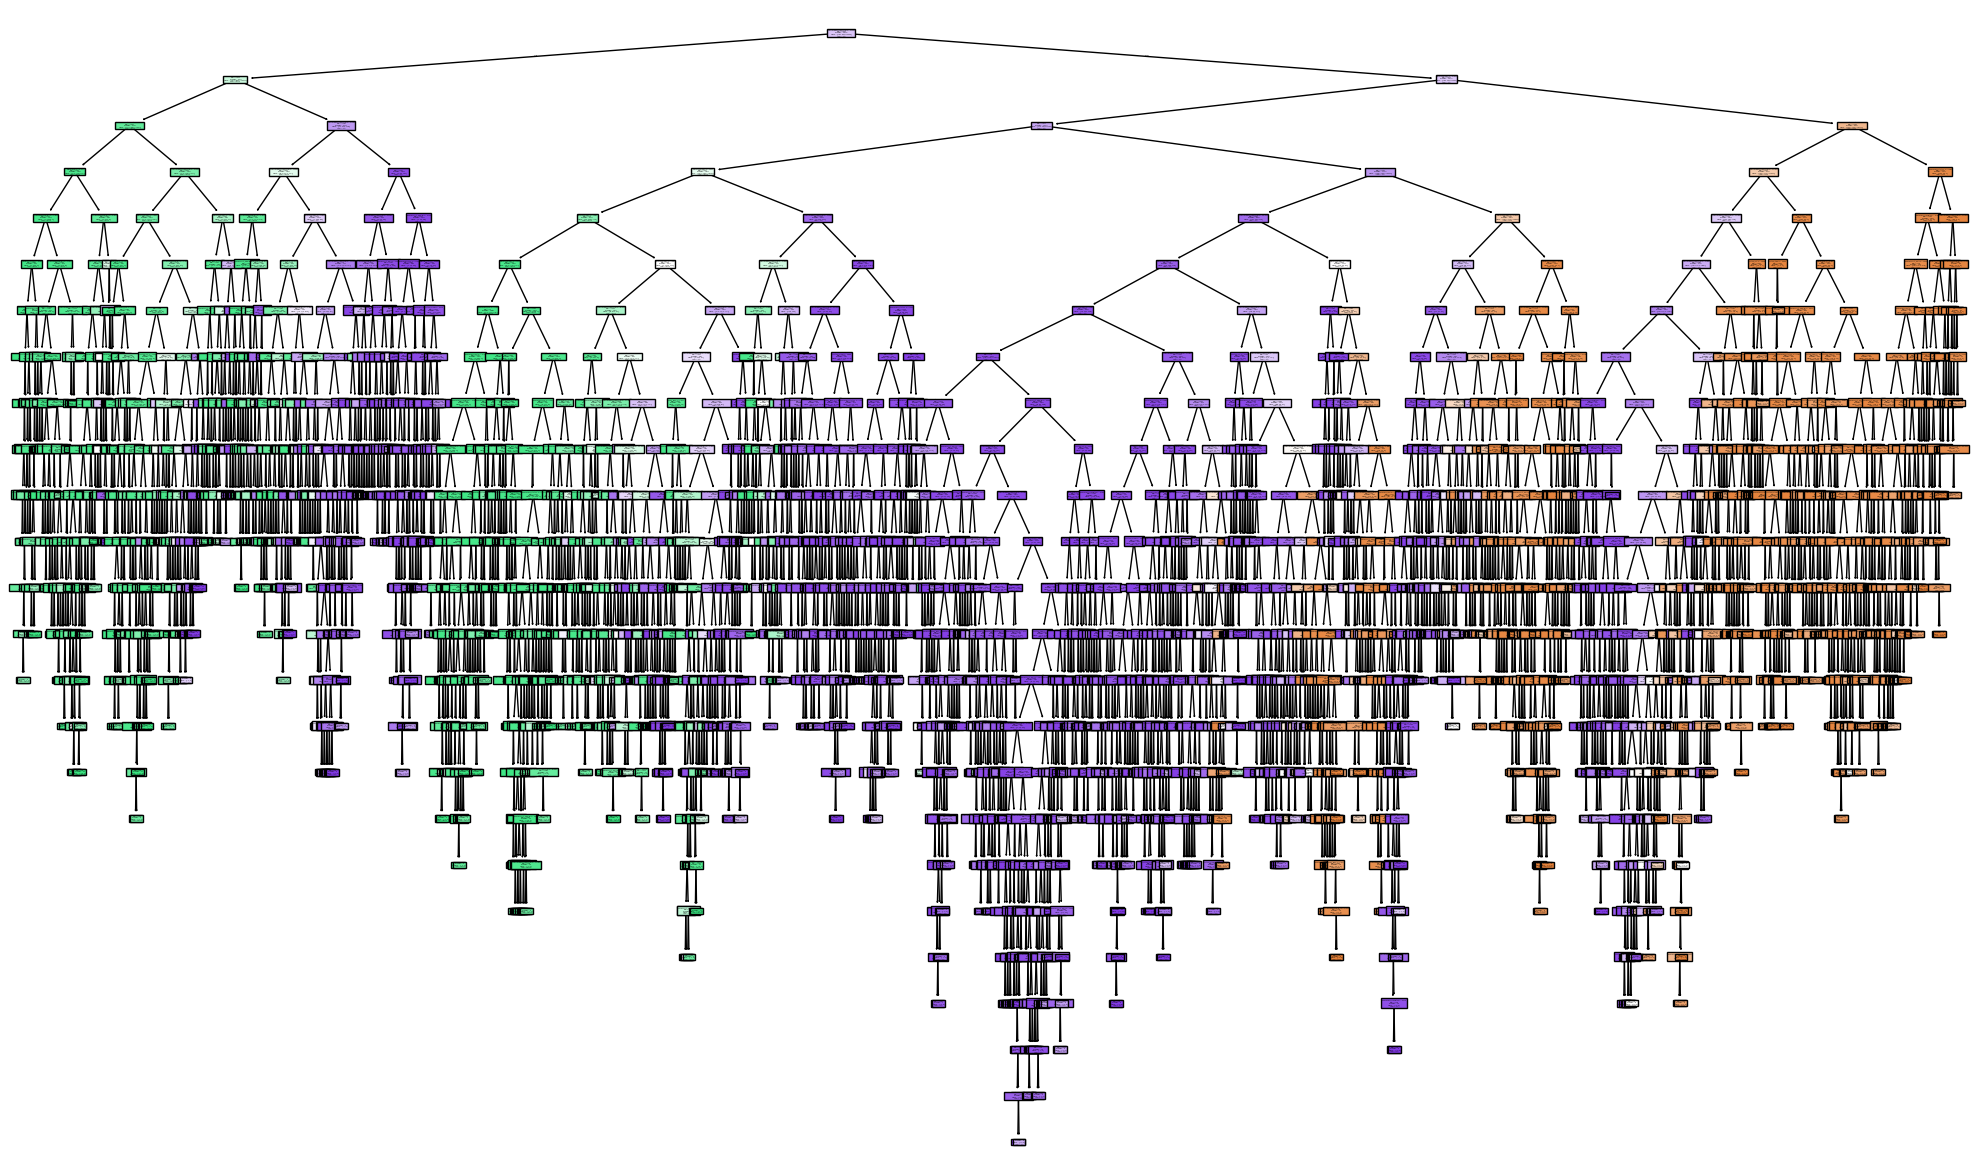

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de árbol de decisión
model = DecisionTreeClassifier( criterion='gini',
    max_depth=None,
    min_samples_leaf=5,
    min_samples_split=4,
    splitter='random',
    random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualizar el árbol de decisión
plt.figure(figsize=(25, 15))
tree.plot_tree(model, filled=True, feature_names=X.columns, class_names=['Bajo', 'Medio', 'Alto'])

# Crear el clasificador de árbol de decisión
model = DecisionTreeClassifier(random_state=42)

# Definir el grid de parámetros
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best' , 'random']
}

# Crear el GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo con los parámetros especificados
grid_search.fit(X_train, y_train)

# Ver los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")

# Evaluar el modelo en el conjunto de prueba
accuracy = grid_search.score(X_test, y_test)
print(f"Accuracy en el conjunto de prueba: {accuracy:.4f}")

# Crear el modelo con los mejores parámetros
best_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    splitter='best',
    random_state=42
)

# Entrenar el modelo
best_model.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred_best = best_model.predict(X_test)

# Evaluar el modelo optimizado
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Accuracy con modelo optimizado: {accuracy_best * 100:.2f}%')